In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import get_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})

In [5]:
shifts_folder = 'G:\\My Drive\\UHCICAGO\\Thesis\\URSSE\\shifts'
shift_folders = os.listdir(shifts_folder)
shift_folders

['shift_02_26_2020']

In [9]:
shift = os.path.join(shifts_folder, shift_folders[0])
files = os.listdir(shift)
files

['about300electrons_stray_light_000.ptu',
 'about300electrons_stray_light_002.ptu',
 'about300electrons_stray_light_noise_level_000.ptu',
 'test_multiple_channels_000.ptu']

In [24]:
file = [os.path.join(shift,f) for f in files][0]

In [25]:
f = HydraHarpFile(file,safemode=False)

MemoryError: 

In [16]:
df, n_revolutions = get_event_delays(f,channel=1)
t_delays = df.delay

In [17]:
df.head()

,delay,revolution
57283,52260.0,57283
139840,96033.0,139839
167246,41624.0,167244
199342,127969.0,199339
226621,46342.0,226617


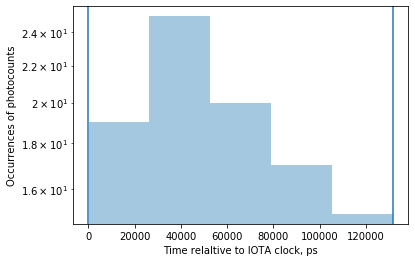

In [19]:
ax =sns.distplot(t_delays,kde=False,bins=5)
ax.set_yscale('log')
ax.set_ylabel('Occurrences of photocounts')
ax.set_xlabel('Time relaltive to IOTA clock, ps')
gate = (0,t_delays.max())#(59000,70000)
plt.axvline(gate[0])
plt.axvline(gate[1])
plt.savefig("photocounts_hist2.png")
plt.show()

In [20]:
counts_revolutions = df.revolution.values[df.delay.between(gate[0],gate[1])]
if np.any(np.diff(counts_revolutions)==0):
    raise Exception("More than one event per revolution within the gate encountered. But it should never happen!")

In [21]:
events = np.zeros(n_revolutions,dtype = np.uint8) 
np.put(events,counts_revolutions,1)
events

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [22]:
p_measured = sum(events)/n_revolutions
print("p_measured = {:.6f}".format(p_measured))
n_of_chuncks = 50
chunk_length = n_revolutions // n_of_chuncks
new_length = n_of_chuncks * chunk_length
chunks = np.reshape(events[:new_length],(n_of_chuncks,chunk_length))
print("chunk length = ",chunk_length)
n_events = sum(events)
print("n_events = ",n_events)
fanos = [calc_Fano_from_counts_per_time_window(x) for x in chunks]
fanos = sorted(fanos)
i1 = int(0.16*len(fanos))
i2 = int(0.84*len(fanos))
f1 = fanos[i1]
f2 = fanos[i2]
error = (f2-f1)/2
print("absolute fano error = ",error)

p_measured = 0.000013
chunk length =  150041
n_events =  96
absolute fano error =  9.99726741335305e-06


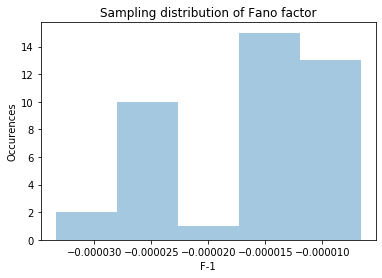

In [23]:
sns.distplot(fanos,kde=False,bins=5)
plt.xlabel("F-1")
plt.ylabel("Occurences")
plt.title("Sampling distribution of Fano factor")
plt.show()